# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [44]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [45]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

## 2/ GAN parameters

In [4]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [32]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)# FILL IN HERE
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2) # FILL IN HERE
    self.fc3 = nn.Linear(self.h_dim_2, 784)# FILL IN HERE
  def forward(self, z):
    y = nn.Tanh()(self.fc3(nn.LeakyReLU(0.2)(self.fc2(nn.LeakyReLU(0.2)(self.fc1(z)))))).view(-1, self.n_channels, self.n_rows, self.n_cols)  # FILL IN HERE

    return(y)


In [26]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = nn.Sigmoid()(self.fc3(nn.LeakyReLU(0.2)(self.fc2(nn.LeakyReLU(0.2)(self.fc1(x.view(-1, self.n_pixels * self.n_channels))))))) # FILL IN HERE
    return y




Create generator and discriminator 

In [46]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels)# FILL IN HERE
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [47]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss() # FILL IN HERE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))  # FILL IN CODE
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [48]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.1673	Loss_G: -0.7989	D(x): 0.7425	D(G(z)): 0.5800


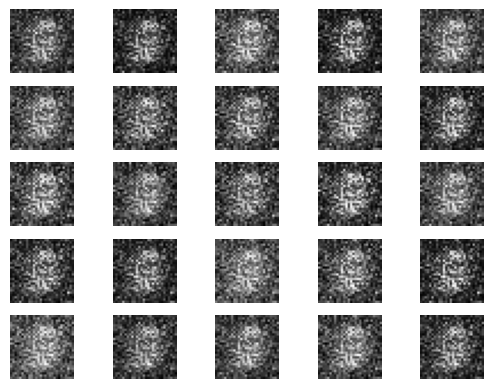

[1/400][0/16] 	Loss_D: 1.1373	Loss_G: -0.6395	D(x): 0.6967	D(G(z)): 0.5388
[2/400][0/16] 	Loss_D: 1.4327	Loss_G: -0.6982	D(x): 0.6356	D(G(z)): 0.6206
[3/400][0/16] 	Loss_D: 1.0709	Loss_G: -0.4364	D(x): 0.7042	D(G(z)): 0.5036
[4/400][0/16] 	Loss_D: 0.5409	Loss_G: -0.2321	D(x): 0.8173	D(G(z)): 0.2848
[5/400][0/16] 	Loss_D: 3.1226	Loss_G: -1.5187	D(x): 0.9742	D(G(z)): 0.9370
[6/400][0/16] 	Loss_D: 0.2058	Loss_G: -0.0898	D(x): 0.9129	D(G(z)): 0.1071
[7/400][0/16] 	Loss_D: 0.1046	Loss_G: -0.0466	D(x): 0.9662	D(G(z)): 0.0659
[8/400][0/16] 	Loss_D: 0.4552	Loss_G: -0.2722	D(x): 0.8365	D(G(z)): 0.1880
[9/400][0/16] 	Loss_D: 0.6827	Loss_G: -0.4159	D(x): 0.7434	D(G(z)): 0.2795
[10/400][0/16] 	Loss_D: 0.9414	Loss_G: -0.5383	D(x): 0.6184	D(G(z)): 0.3603
[11/400][0/16] 	Loss_D: 1.0301	Loss_G: -0.3171	D(x): 0.6952	D(G(z)): 0.4826
[12/400][0/16] 	Loss_D: 1.1517	Loss_G: -0.3691	D(x): 0.6660	D(G(z)): 0.5205
[13/400][0/16] 	Loss_D: 0.9004	Loss_G: -0.4910	D(x): 0.5529	D(G(z)): 0.2395
[14/400][0/16] 	Loss_

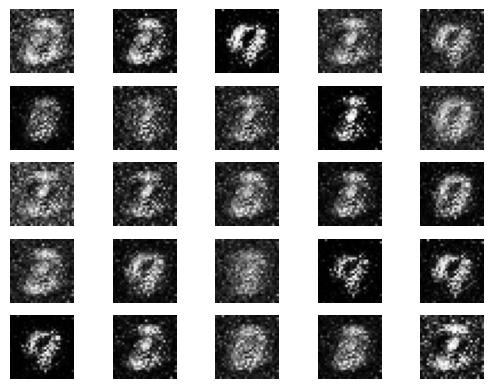

[26/400][0/16] 	Loss_D: 1.0034	Loss_G: -0.4936	D(x): 0.5633	D(G(z)): 0.3122
[27/400][0/16] 	Loss_D: 0.8858	Loss_G: -0.1982	D(x): 0.7859	D(G(z)): 0.4616
[28/400][0/16] 	Loss_D: 1.1464	Loss_G: -0.2603	D(x): 0.7398	D(G(z)): 0.5491
[29/400][0/16] 	Loss_D: 0.3894	Loss_G: -0.0942	D(x): 0.8983	D(G(z)): 0.2409
[30/400][0/16] 	Loss_D: 1.1059	Loss_G: -0.3390	D(x): 0.6321	D(G(z)): 0.4456
[31/400][0/16] 	Loss_D: 0.5747	Loss_G: -0.2657	D(x): 0.7048	D(G(z)): 0.1711
[32/400][0/16] 	Loss_D: 1.0717	Loss_G: -0.4265	D(x): 0.6167	D(G(z)): 0.3714
[33/400][0/16] 	Loss_D: 1.2396	Loss_G: -0.1579	D(x): 0.9418	D(G(z)): 0.6588
[34/400][0/16] 	Loss_D: 0.6927	Loss_G: -0.2276	D(x): 0.8106	D(G(z)): 0.3647
[35/400][0/16] 	Loss_D: 0.6585	Loss_G: -0.2372	D(x): 0.7409	D(G(z)): 0.2713
[36/400][0/16] 	Loss_D: 0.8525	Loss_G: -0.3305	D(x): 0.6823	D(G(z)): 0.3575
[37/400][0/16] 	Loss_D: 0.5058	Loss_G: -0.0749	D(x): 0.8744	D(G(z)): 0.2952
[38/400][0/16] 	Loss_D: 0.8946	Loss_G: -0.1518	D(x): 0.8679	D(G(z)): 0.5077
[39/400][0/1

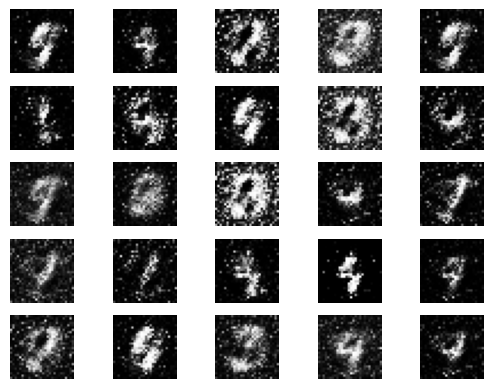

[51/400][0/16] 	Loss_D: 0.3439	Loss_G: -0.1802	D(x): 0.8351	D(G(z)): 0.1171
[52/400][0/16] 	Loss_D: 0.9345	Loss_G: -0.5415	D(x): 0.5678	D(G(z)): 0.1783
[53/400][0/16] 	Loss_D: 0.7649	Loss_G: -0.2473	D(x): 0.6489	D(G(z)): 0.2012
[54/400][0/16] 	Loss_D: 0.5214	Loss_G: -0.1549	D(x): 0.7961	D(G(z)): 0.2270
[55/400][0/16] 	Loss_D: 0.6568	Loss_G: -0.1539	D(x): 0.8242	D(G(z)): 0.3222
[56/400][0/16] 	Loss_D: 1.4753	Loss_G: -0.0511	D(x): 0.9187	D(G(z)): 0.6953
[57/400][0/16] 	Loss_D: 0.5447	Loss_G: -0.1271	D(x): 0.8633	D(G(z)): 0.2912
[58/400][0/16] 	Loss_D: 0.8830	Loss_G: -0.7695	D(x): 0.5876	D(G(z)): 0.1615
[59/400][0/16] 	Loss_D: 0.4604	Loss_G: -0.1952	D(x): 0.7702	D(G(z)): 0.1547
[60/400][0/16] 	Loss_D: 1.3359	Loss_G: -0.0450	D(x): 0.9621	D(G(z)): 0.6695
[61/400][0/16] 	Loss_D: 0.8606	Loss_G: -0.7664	D(x): 0.5858	D(G(z)): 0.1973
[62/400][0/16] 	Loss_D: 0.6628	Loss_G: -0.1886	D(x): 0.7279	D(G(z)): 0.2211
[63/400][0/16] 	Loss_D: 1.5549	Loss_G: -0.2583	D(x): 0.8347	D(G(z)): 0.6562
[64/400][0/1

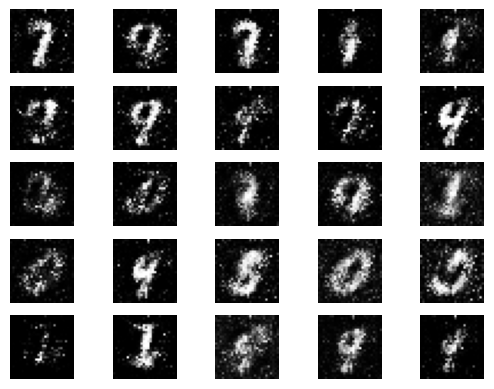

[76/400][0/16] 	Loss_D: 0.5264	Loss_G: -0.4108	D(x): 0.7400	D(G(z)): 0.1375
[77/400][0/16] 	Loss_D: 0.5310	Loss_G: -0.1271	D(x): 0.7833	D(G(z)): 0.1954
[78/400][0/16] 	Loss_D: 0.4015	Loss_G: -0.2176	D(x): 0.8277	D(G(z)): 0.1619
[79/400][0/16] 	Loss_D: 0.5564	Loss_G: -0.0650	D(x): 0.8705	D(G(z)): 0.3120
[80/400][0/16] 	Loss_D: 1.5131	Loss_G: -0.0088	D(x): 0.9851	D(G(z)): 0.7201
[81/400][0/16] 	Loss_D: 0.4998	Loss_G: -0.1373	D(x): 0.7516	D(G(z)): 0.1233
[82/400][0/16] 	Loss_D: 0.4698	Loss_G: -0.0979	D(x): 0.9269	D(G(z)): 0.2945
[83/400][0/16] 	Loss_D: 0.6300	Loss_G: -0.4096	D(x): 0.6655	D(G(z)): 0.0437
[84/400][0/16] 	Loss_D: 1.0655	Loss_G: -0.4577	D(x): 0.5548	D(G(z)): 0.1288
[85/400][0/16] 	Loss_D: 0.8478	Loss_G: -0.0512	D(x): 0.9360	D(G(z)): 0.4870
[86/400][0/16] 	Loss_D: 0.4541	Loss_G: -0.1283	D(x): 0.7856	D(G(z)): 0.1240
[87/400][0/16] 	Loss_D: 0.8985	Loss_G: -0.0229	D(x): 0.9413	D(G(z)): 0.4836
[88/400][0/16] 	Loss_D: 0.4671	Loss_G: -0.2260	D(x): 0.7538	D(G(z)): 0.0863
[89/400][0/1

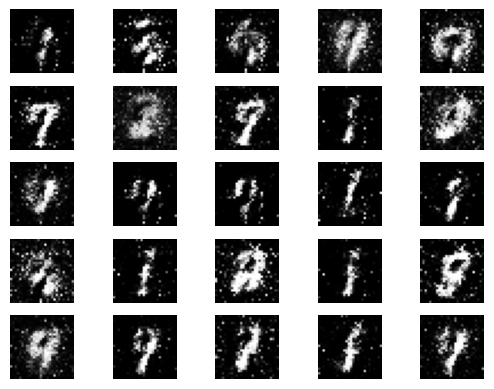

[101/400][0/16] 	Loss_D: 1.6233	Loss_G: -0.8318	D(x): 0.3331	D(G(z)): 0.0123
[102/400][0/16] 	Loss_D: 0.8166	Loss_G: -0.6090	D(x): 0.5790	D(G(z)): 0.0537
[103/400][0/16] 	Loss_D: 0.4461	Loss_G: -0.0911	D(x): 0.8677	D(G(z)): 0.2262
[104/400][0/16] 	Loss_D: 0.6868	Loss_G: -0.0221	D(x): 0.9294	D(G(z)): 0.4093
[105/400][0/16] 	Loss_D: 0.6267	Loss_G: -0.2139	D(x): 0.7180	D(G(z)): 0.1218
[106/400][0/16] 	Loss_D: 0.3575	Loss_G: -0.1618	D(x): 0.8154	D(G(z)): 0.1101
[107/400][0/16] 	Loss_D: 0.4209	Loss_G: -0.2221	D(x): 0.7951	D(G(z)): 0.1157
[108/400][0/16] 	Loss_D: 1.5494	Loss_G: -0.9383	D(x): 0.3562	D(G(z)): 0.0124
[109/400][0/16] 	Loss_D: 0.5936	Loss_G: -0.1455	D(x): 0.8608	D(G(z)): 0.3070
[110/400][0/16] 	Loss_D: 0.4506	Loss_G: -0.1584	D(x): 0.8573	D(G(z)): 0.2035
[111/400][0/16] 	Loss_D: 0.3944	Loss_G: -0.3263	D(x): 0.7963	D(G(z)): 0.1089
[112/400][0/16] 	Loss_D: 0.4832	Loss_G: -0.2574	D(x): 0.8299	D(G(z)): 0.2077
[113/400][0/16] 	Loss_D: 0.3967	Loss_G: -0.1061	D(x): 0.8608	D(G(z)): 0.1798

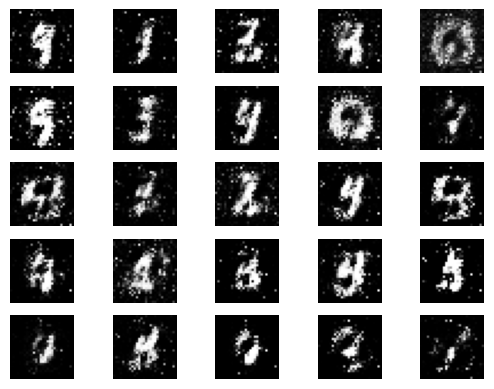

[126/400][0/16] 	Loss_D: 0.9835	Loss_G: -0.0449	D(x): 0.9242	D(G(z)): 0.5496
[127/400][0/16] 	Loss_D: 0.6244	Loss_G: -0.1096	D(x): 0.8712	D(G(z)): 0.3487
[128/400][0/16] 	Loss_D: 0.3399	Loss_G: -0.0932	D(x): 0.8996	D(G(z)): 0.1928
[129/400][0/16] 	Loss_D: 1.5095	Loss_G: -1.4802	D(x): 0.3324	D(G(z)): 0.0126
[130/400][0/16] 	Loss_D: 0.5333	Loss_G: -0.2611	D(x): 0.7645	D(G(z)): 0.1893
[131/400][0/16] 	Loss_D: 0.3654	Loss_G: -0.1783	D(x): 0.8754	D(G(z)): 0.1858
[132/400][0/16] 	Loss_D: 0.3638	Loss_G: -0.1429	D(x): 0.8094	D(G(z)): 0.0878
[133/400][0/16] 	Loss_D: 0.4801	Loss_G: -0.2757	D(x): 0.7473	D(G(z)): 0.1276
[134/400][0/16] 	Loss_D: 0.4753	Loss_G: -0.1989	D(x): 0.7257	D(G(z)): 0.0688
[135/400][0/16] 	Loss_D: 0.9514	Loss_G: -1.6016	D(x): 0.4938	D(G(z)): 0.0265
[136/400][0/16] 	Loss_D: 0.3537	Loss_G: -0.0968	D(x): 0.9056	D(G(z)): 0.2061
[137/400][0/16] 	Loss_D: 0.5825	Loss_G: -0.6315	D(x): 0.6414	D(G(z)): 0.0432
[138/400][0/16] 	Loss_D: 0.7335	Loss_G: -0.1115	D(x): 0.8770	D(G(z)): 0.3816

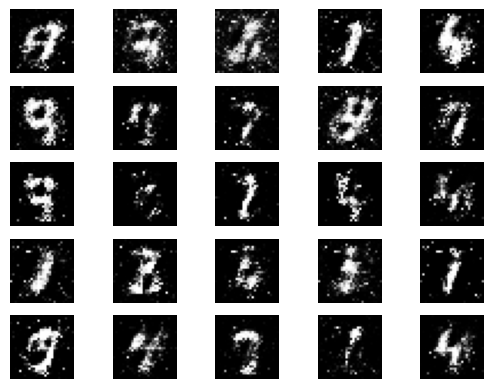

[151/400][0/16] 	Loss_D: 0.4786	Loss_G: -0.0812	D(x): 0.8607	D(G(z)): 0.2276
[152/400][0/16] 	Loss_D: 0.5096	Loss_G: -0.1278	D(x): 0.8634	D(G(z)): 0.2580
[153/400][0/16] 	Loss_D: 0.6125	Loss_G: -0.1112	D(x): 0.8953	D(G(z)): 0.3495
[154/400][0/16] 	Loss_D: 0.7907	Loss_G: -0.6369	D(x): 0.5931	D(G(z)): 0.0800
[155/400][0/16] 	Loss_D: 0.5543	Loss_G: -0.2190	D(x): 0.7713	D(G(z)): 0.1968
[156/400][0/16] 	Loss_D: 0.3944	Loss_G: -0.0947	D(x): 0.8814	D(G(z)): 0.1784
[157/400][0/16] 	Loss_D: 0.5346	Loss_G: -0.3230	D(x): 0.6919	D(G(z)): 0.0488
[158/400][0/16] 	Loss_D: 0.3960	Loss_G: -0.0553	D(x): 0.8979	D(G(z)): 0.2137
[159/400][0/16] 	Loss_D: 0.7713	Loss_G: -0.3379	D(x): 0.6240	D(G(z)): 0.0635
[160/400][0/16] 	Loss_D: 0.5386	Loss_G: -0.0644	D(x): 0.8565	D(G(z)): 0.2708
[161/400][0/16] 	Loss_D: 0.8402	Loss_G: -0.0162	D(x): 0.9256	D(G(z)): 0.4822
[162/400][0/16] 	Loss_D: 0.6915	Loss_G: -0.6876	D(x): 0.6268	D(G(z)): 0.0559
[163/400][0/16] 	Loss_D: 0.3459	Loss_G: -0.2236	D(x): 0.8288	D(G(z)): 0.1071

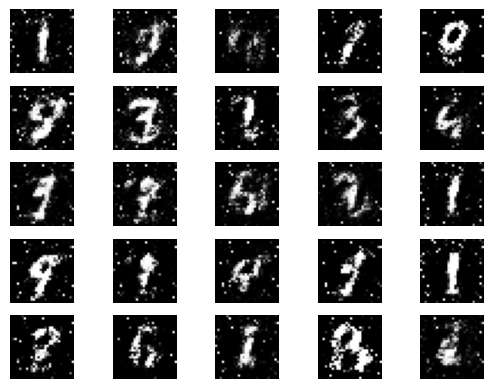

[176/400][0/16] 	Loss_D: 0.5238	Loss_G: -0.3484	D(x): 0.6998	D(G(z)): 0.0540
[177/400][0/16] 	Loss_D: 0.8807	Loss_G: -0.0167	D(x): 0.9485	D(G(z)): 0.4752
[178/400][0/16] 	Loss_D: 0.3644	Loss_G: -0.1555	D(x): 0.8088	D(G(z)): 0.0910
[179/400][0/16] 	Loss_D: 0.3102	Loss_G: -0.1017	D(x): 0.8789	D(G(z)): 0.1323
[180/400][0/16] 	Loss_D: 0.2490	Loss_G: -0.1532	D(x): 0.8817	D(G(z)): 0.0924
[181/400][0/16] 	Loss_D: 0.4122	Loss_G: -0.0735	D(x): 0.9359	D(G(z)): 0.2667
[182/400][0/16] 	Loss_D: 1.5769	Loss_G: -0.6885	D(x): 0.3655	D(G(z)): 0.0242
[183/400][0/16] 	Loss_D: 0.4733	Loss_G: -0.2247	D(x): 0.8114	D(G(z)): 0.1820
[184/400][0/16] 	Loss_D: 0.6727	Loss_G: -0.0817	D(x): 0.9231	D(G(z)): 0.3584
[185/400][0/16] 	Loss_D: 0.4906	Loss_G: -0.0252	D(x): 0.9379	D(G(z)): 0.2884
[186/400][0/16] 	Loss_D: 0.8149	Loss_G: -0.1138	D(x): 0.8709	D(G(z)): 0.3314
[187/400][0/16] 	Loss_D: 0.2578	Loss_G: -0.0656	D(x): 0.8828	D(G(z)): 0.1019
[188/400][0/16] 	Loss_D: 0.4007	Loss_G: -0.1359	D(x): 0.8737	D(G(z)): 0.1951

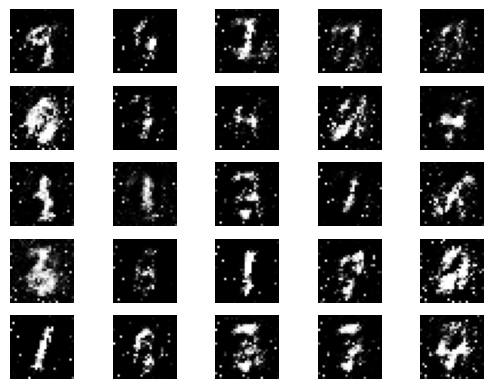

[201/400][0/16] 	Loss_D: 0.1725	Loss_G: -0.0619	D(x): 0.9073	D(G(z)): 0.0578
[202/400][0/16] 	Loss_D: 0.8704	Loss_G: -0.8897	D(x): 0.5877	D(G(z)): 0.0193
[203/400][0/16] 	Loss_D: 0.9123	Loss_G: -0.7667	D(x): 0.5601	D(G(z)): 0.0266
[204/400][0/16] 	Loss_D: 0.8511	Loss_G: -0.0298	D(x): 0.9255	D(G(z)): 0.4554
[205/400][0/16] 	Loss_D: 1.3826	Loss_G: -0.0070	D(x): 0.9817	D(G(z)): 0.6872
[206/400][0/16] 	Loss_D: 1.3721	Loss_G: -0.0195	D(x): 0.9555	D(G(z)): 0.6258
[207/400][0/16] 	Loss_D: 0.7100	Loss_G: -0.0176	D(x): 0.9404	D(G(z)): 0.4045
[208/400][0/16] 	Loss_D: 0.4068	Loss_G: -0.1085	D(x): 0.9036	D(G(z)): 0.2284
[209/400][0/16] 	Loss_D: 0.5435	Loss_G: -0.2092	D(x): 0.8288	D(G(z)): 0.2426
[210/400][0/16] 	Loss_D: 0.8032	Loss_G: -0.0722	D(x): 0.9389	D(G(z)): 0.4509
[211/400][0/16] 	Loss_D: 0.9819	Loss_G: -0.0170	D(x): 0.9502	D(G(z)): 0.5144
[212/400][0/16] 	Loss_D: 0.4736	Loss_G: -0.0587	D(x): 0.9313	D(G(z)): 0.2968
[213/400][0/16] 	Loss_D: 0.5347	Loss_G: -0.0544	D(x): 0.9156	D(G(z)): 0.3059

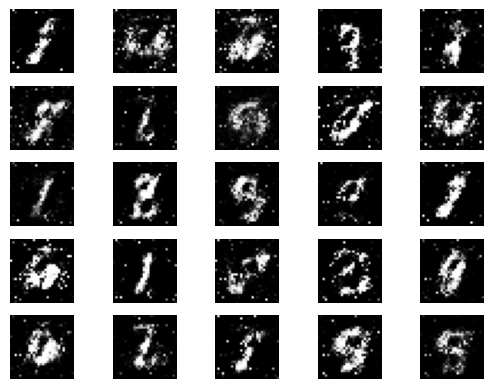

[226/400][0/16] 	Loss_D: 0.4187	Loss_G: -0.0868	D(x): 0.8454	D(G(z)): 0.1482
[227/400][0/16] 	Loss_D: 0.5165	Loss_G: -0.1756	D(x): 0.7362	D(G(z)): 0.1135
[228/400][0/16] 	Loss_D: 0.4391	Loss_G: -0.1000	D(x): 0.8168	D(G(z)): 0.1603
[229/400][0/16] 	Loss_D: 0.6132	Loss_G: -0.3579	D(x): 0.6799	D(G(z)): 0.0660
[230/400][0/16] 	Loss_D: 0.8657	Loss_G: -0.0591	D(x): 0.9022	D(G(z)): 0.4566
[231/400][0/16] 	Loss_D: 0.4159	Loss_G: -0.1660	D(x): 0.8655	D(G(z)): 0.2070
[232/400][0/16] 	Loss_D: 0.4293	Loss_G: -0.1080	D(x): 0.8892	D(G(z)): 0.2329
[233/400][0/16] 	Loss_D: 0.4738	Loss_G: -0.2298	D(x): 0.7665	D(G(z)): 0.1119
[234/400][0/16] 	Loss_D: 0.7317	Loss_G: -0.1936	D(x): 0.6776	D(G(z)): 0.0441
[235/400][0/16] 	Loss_D: 0.3784	Loss_G: -0.2337	D(x): 0.8177	D(G(z)): 0.1110
[236/400][0/16] 	Loss_D: 0.5051	Loss_G: -0.0927	D(x): 0.8907	D(G(z)): 0.2555
[237/400][0/16] 	Loss_D: 0.4776	Loss_G: -0.3746	D(x): 0.7871	D(G(z)): 0.1521
[238/400][0/16] 	Loss_D: 0.8939	Loss_G: -0.4411	D(x): 0.5431	D(G(z)): 0.0428

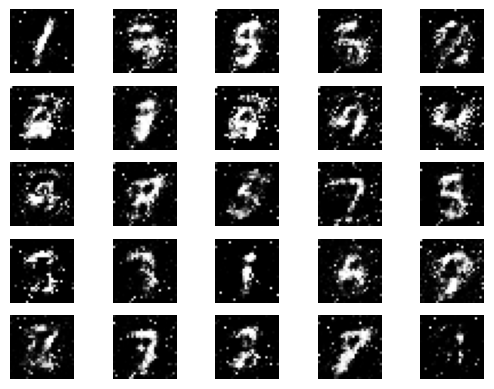

[251/400][0/16] 	Loss_D: 0.4913	Loss_G: -0.1998	D(x): 0.8065	D(G(z)): 0.1775
[252/400][0/16] 	Loss_D: 1.3871	Loss_G: -0.0078	D(x): 0.9703	D(G(z)): 0.6558
[253/400][0/16] 	Loss_D: 1.0608	Loss_G: -0.7224	D(x): 0.4943	D(G(z)): 0.0669
[254/400][0/16] 	Loss_D: 0.5516	Loss_G: -0.3618	D(x): 0.7176	D(G(z)): 0.0998
[255/400][0/16] 	Loss_D: 0.3910	Loss_G: -0.1818	D(x): 0.7724	D(G(z)): 0.0687
[256/400][0/16] 	Loss_D: 0.3226	Loss_G: -0.0822	D(x): 0.8966	D(G(z)): 0.1645
[257/400][0/16] 	Loss_D: 0.4897	Loss_G: -0.1852	D(x): 0.8040	D(G(z)): 0.1774
[258/400][0/16] 	Loss_D: 1.2006	Loss_G: -0.0335	D(x): 0.9627	D(G(z)): 0.6241
[259/400][0/16] 	Loss_D: 0.3465	Loss_G: -0.1282	D(x): 0.8790	D(G(z)): 0.1608
[260/400][0/16] 	Loss_D: 0.3691	Loss_G: -0.1821	D(x): 0.8112	D(G(z)): 0.0952
[261/400][0/16] 	Loss_D: 1.3847	Loss_G: -0.7598	D(x): 0.4540	D(G(z)): 0.0107
[262/400][0/16] 	Loss_D: 0.5638	Loss_G: -0.2754	D(x): 0.6723	D(G(z)): 0.0409
[263/400][0/16] 	Loss_D: 0.5859	Loss_G: -0.1580	D(x): 0.9376	D(G(z)): 0.3527

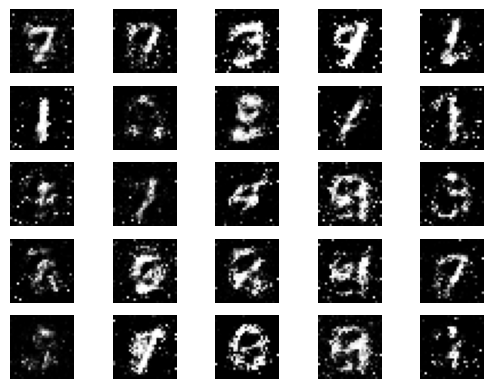

[276/400][0/16] 	Loss_D: 1.1157	Loss_G: -0.6695	D(x): 0.5090	D(G(z)): 0.0229
[277/400][0/16] 	Loss_D: 0.3950	Loss_G: -0.1158	D(x): 0.9352	D(G(z)): 0.2513
[278/400][0/16] 	Loss_D: 2.3677	Loss_G: -0.0060	D(x): 0.9900	D(G(z)): 0.8009
[279/400][0/16] 	Loss_D: 0.4385	Loss_G: -0.2199	D(x): 0.8514	D(G(z)): 0.1963
[280/400][0/16] 	Loss_D: 0.3294	Loss_G: -0.0780	D(x): 0.9230	D(G(z)): 0.1958
[281/400][0/16] 	Loss_D: 0.3287	Loss_G: -0.1809	D(x): 0.8037	D(G(z)): 0.0463
[282/400][0/16] 	Loss_D: 1.4286	Loss_G: -0.0050	D(x): 0.9739	D(G(z)): 0.6782
[283/400][0/16] 	Loss_D: 0.3583	Loss_G: -0.1450	D(x): 0.8589	D(G(z)): 0.1476
[284/400][0/16] 	Loss_D: 0.3178	Loss_G: -0.1824	D(x): 0.8491	D(G(z)): 0.1066
[285/400][0/16] 	Loss_D: 0.5498	Loss_G: -0.2569	D(x): 0.7521	D(G(z)): 0.1281
[286/400][0/16] 	Loss_D: 0.4128	Loss_G: -0.1315	D(x): 0.8047	D(G(z)): 0.0958
[287/400][0/16] 	Loss_D: 0.4661	Loss_G: -0.3832	D(x): 0.7928	D(G(z)): 0.1242
[288/400][0/16] 	Loss_D: 0.3755	Loss_G: -0.0770	D(x): 0.8641	D(G(z)): 0.1611

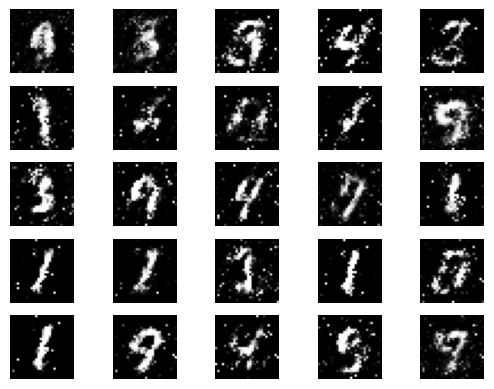

[301/400][0/16] 	Loss_D: 0.5407	Loss_G: -0.1676	D(x): 0.8334	D(G(z)): 0.1997
[302/400][0/16] 	Loss_D: 0.4021	Loss_G: -0.1227	D(x): 0.8181	D(G(z)): 0.0897
[303/400][0/16] 	Loss_D: 0.5353	Loss_G: -0.0678	D(x): 0.9593	D(G(z)): 0.3396
[304/400][0/16] 	Loss_D: 0.7540	Loss_G: -0.5025	D(x): 0.6408	D(G(z)): 0.0927
[305/400][0/16] 	Loss_D: 0.4193	Loss_G: -0.2008	D(x): 0.8399	D(G(z)): 0.1598
[306/400][0/16] 	Loss_D: 0.4131	Loss_G: -0.2608	D(x): 0.7516	D(G(z)): 0.0344
[307/400][0/16] 	Loss_D: 0.4441	Loss_G: -0.0843	D(x): 0.8708	D(G(z)): 0.2194
[308/400][0/16] 	Loss_D: 0.5349	Loss_G: -0.0877	D(x): 0.8447	D(G(z)): 0.2330
[309/400][0/16] 	Loss_D: 0.4147	Loss_G: -0.1622	D(x): 0.8379	D(G(z)): 0.1590
[310/400][0/16] 	Loss_D: 0.5175	Loss_G: -0.2357	D(x): 0.7666	D(G(z)): 0.1266
[311/400][0/16] 	Loss_D: 0.5852	Loss_G: -0.1500	D(x): 0.8612	D(G(z)): 0.2844
[312/400][0/16] 	Loss_D: 0.6126	Loss_G: -0.0540	D(x): 0.8719	D(G(z)): 0.2890
[313/400][0/16] 	Loss_D: 0.6692	Loss_G: -0.2785	D(x): 0.9079	D(G(z)): 0.3480

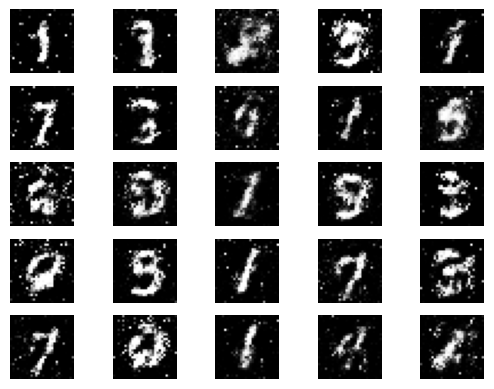

[326/400][0/16] 	Loss_D: 0.3684	Loss_G: -0.1781	D(x): 0.8640	D(G(z)): 0.1638
[327/400][0/16] 	Loss_D: 0.9296	Loss_G: -0.4635	D(x): 0.5977	D(G(z)): 0.1357
[328/400][0/16] 	Loss_D: 0.5581	Loss_G: -0.1625	D(x): 0.8865	D(G(z)): 0.3067
[329/400][0/16] 	Loss_D: 0.4122	Loss_G: -0.2694	D(x): 0.7834	D(G(z)): 0.1029
[330/400][0/16] 	Loss_D: 0.6083	Loss_G: -0.0786	D(x): 0.8146	D(G(z)): 0.2655
[331/400][0/16] 	Loss_D: 0.5013	Loss_G: -0.1194	D(x): 0.8509	D(G(z)): 0.2338
[332/400][0/16] 	Loss_D: 0.4747	Loss_G: -0.1809	D(x): 0.8193	D(G(z)): 0.1866
[333/400][0/16] 	Loss_D: 0.4774	Loss_G: -0.2575	D(x): 0.7732	D(G(z)): 0.1134
[334/400][0/16] 	Loss_D: 1.3834	Loss_G: -0.3167	D(x): 0.4343	D(G(z)): 0.0138
[335/400][0/16] 	Loss_D: 0.3957	Loss_G: -0.1994	D(x): 0.8122	D(G(z)): 0.1273
[336/400][0/16] 	Loss_D: 0.5452	Loss_G: -0.0455	D(x): 0.9251	D(G(z)): 0.3271
[337/400][0/16] 	Loss_D: 0.5566	Loss_G: -0.0778	D(x): 0.9300	D(G(z)): 0.3149
[338/400][0/16] 	Loss_D: 0.3131	Loss_G: -0.0848	D(x): 0.9301	D(G(z)): 0.1896

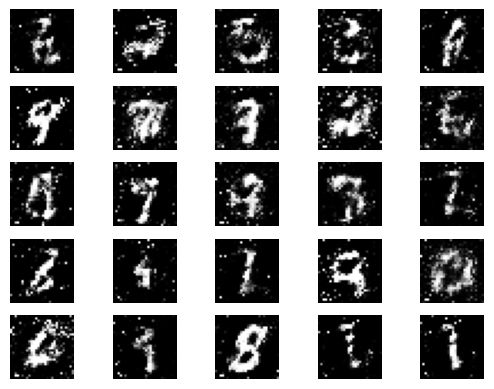

[351/400][0/16] 	Loss_D: 0.8119	Loss_G: -0.3442	D(x): 0.6789	D(G(z)): 0.1804
[352/400][0/16] 	Loss_D: 0.4676	Loss_G: -0.2631	D(x): 0.7847	D(G(z)): 0.1571
[353/400][0/16] 	Loss_D: 0.6659	Loss_G: -0.2567	D(x): 0.6374	D(G(z)): 0.0582
[354/400][0/16] 	Loss_D: 0.4989	Loss_G: -0.1510	D(x): 0.8781	D(G(z)): 0.2577
[355/400][0/16] 	Loss_D: 0.5922	Loss_G: -0.2487	D(x): 0.7537	D(G(z)): 0.1702
[356/400][0/16] 	Loss_D: 0.8350	Loss_G: -0.8612	D(x): 0.5606	D(G(z)): 0.0759
[357/400][0/16] 	Loss_D: 0.6462	Loss_G: -0.3707	D(x): 0.6740	D(G(z)): 0.0799
[358/400][0/16] 	Loss_D: 0.4457	Loss_G: -0.1912	D(x): 0.8093	D(G(z)): 0.1642
[359/400][0/16] 	Loss_D: 0.4614	Loss_G: -0.1893	D(x): 0.7857	D(G(z)): 0.1333
[360/400][0/16] 	Loss_D: 0.4920	Loss_G: -0.3607	D(x): 0.7493	D(G(z)): 0.1158
[361/400][0/16] 	Loss_D: 0.5699	Loss_G: -0.2471	D(x): 0.6687	D(G(z)): 0.0442
[362/400][0/16] 	Loss_D: 1.2198	Loss_G: -1.9520	D(x): 0.4085	D(G(z)): 0.0222
[363/400][0/16] 	Loss_D: 0.6840	Loss_G: -0.0921	D(x): 0.8723	D(G(z)): 0.3360

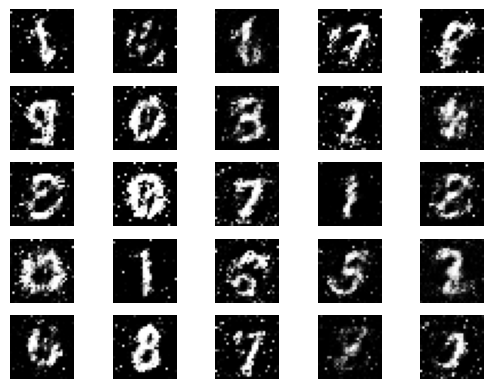

[376/400][0/16] 	Loss_D: 0.5449	Loss_G: -0.4482	D(x): 0.8576	D(G(z)): 0.2567
[377/400][0/16] 	Loss_D: 0.6090	Loss_G: -0.2534	D(x): 0.6886	D(G(z)): 0.1027
[378/400][0/16] 	Loss_D: 0.7764	Loss_G: -0.1389	D(x): 0.9438	D(G(z)): 0.4443
[379/400][0/16] 	Loss_D: 0.7218	Loss_G: -0.7292	D(x): 0.6262	D(G(z)): 0.0835
[380/400][0/16] 	Loss_D: 2.1710	Loss_G: -0.0415	D(x): 0.9893	D(G(z)): 0.8127
[381/400][0/16] 	Loss_D: 1.1078	Loss_G: -0.7174	D(x): 0.4614	D(G(z)): 0.0317
[382/400][0/16] 	Loss_D: 0.5797	Loss_G: -0.1668	D(x): 0.8288	D(G(z)): 0.2570
[383/400][0/16] 	Loss_D: 0.7894	Loss_G: -0.0514	D(x): 0.9079	D(G(z)): 0.4288
[384/400][0/16] 	Loss_D: 0.7476	Loss_G: -0.3805	D(x): 0.6237	D(G(z)): 0.0687
[385/400][0/16] 	Loss_D: 1.0503	Loss_G: -0.7695	D(x): 0.4880	D(G(z)): 0.0281
[386/400][0/16] 	Loss_D: 1.1095	Loss_G: -0.0262	D(x): 0.9431	D(G(z)): 0.5686
[387/400][0/16] 	Loss_D: 0.5791	Loss_G: -0.0457	D(x): 0.9150	D(G(z)): 0.3417
[388/400][0/16] 	Loss_D: 0.6905	Loss_G: -0.3776	D(x): 0.6643	D(G(z)): 0.0977

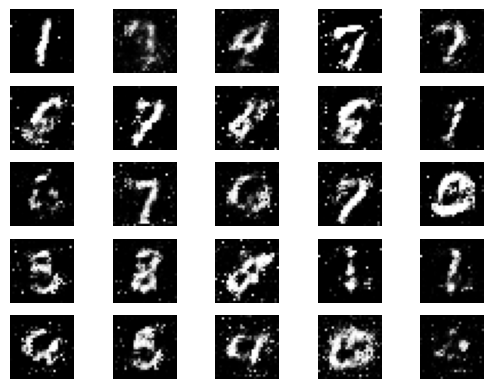

In [51]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels
      true_imgs =  data[0].to(device) # FILL IN HERE
      true_labels = torch.ones((true_imgs.size(0), 1)) # FILL IN HERE
      # put true data through discriminator
      d_output_true = disc_model(true_imgs) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(batch_size, z_dim) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise) # FILL IN HERE
      fake_labels = torch.zeros((batch_size, 1)) # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs) # FILL IN HERE
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels) # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(gen_model(torch.randn(batch_size, z_dim))) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

856
97


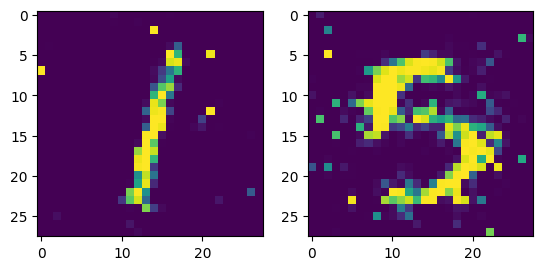

In [235]:
# first image
random_seed = np.random.randint(0,1000)# change this seed to find the best image
print(random_seed)
torch.manual_seed(random_seed)
z_0 = torch.randn(z_dim) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = np.random.randint(0,1000)# change this seed to find the best image
print(random_seed)
torch.manual_seed(random_seed)
z_1 = torch.randn(z_dim) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE


# display images
# FILL IN HERE
fig, ax = plt.subplots(1,2)

ax[0].imshow(pytorch_to_numpy(x_0[0,0, :,:]))
ax[1].imshow(pytorch_to_numpy(x_1[0,0, :,:]))

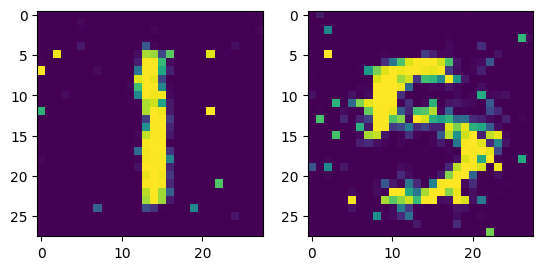

In [236]:
# first image
random_seed = 978# change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(z_dim) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 97# change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.randn(z_dim) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE


# display images
# FILL IN HERE
fig, ax = plt.subplots(1,2)

ax[0].imshow(pytorch_to_numpy(x_0[0,0, :,:]))
ax[1].imshow(pytorch_to_numpy(x_1[0,0, :,:]))

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [237]:
n_interpolation = 20

# FILL IN HERE
t = np.linspace(0,1,num=n_interpolation)
z_tab = torch.lerp(z_0, z_1,torch.tensor(t, dtype=torch.float32).view(-1, 1))

interpolated_imgs = gen_model(z_tab)

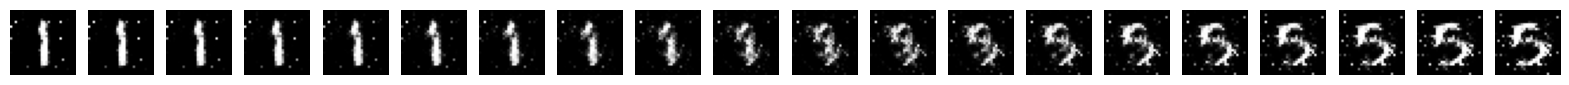

In [238]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow(pytorch_to_numpy(interpolated_imgs[i, 0, :,:]) , cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

The interpolated mid_navigation do not ressemble any number. Maybe we could try a diffrent type of interpolation (bicubic for example), because the relationship between the latent space and the image space isn't linear.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [105]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    torch.nn.Conv2d(n_h_0, n_h_1, kernel_size, padding=0, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(n_h_1, n_h_2, kernel_size, padding=0, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(12*12*nb_filters, nb_classes))
    

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [106]:
# training the classifier

# FILL IN HERE
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0105 Accuracy:0.9250
Epoch:1 Train Loss:0.0098 Accuracy:0.8250
Epoch:2 Train Loss:0.0029 Accuracy:0.9250
Epoch:3 Train Loss:0.0020 Accuracy:0.9750
Epoch:4 Train Loss:0.0024 Accuracy:0.9750
Epoch:5 Train Loss:0.0009 Accuracy:1.0000
Epoch:6 Train Loss:0.0002 Accuracy:1.0000
Epoch:7 Train Loss:0.0005 Accuracy:1.0000
Epoch:8 Train Loss:0.0000 Accuracy:1.0000
Epoch:9 Train Loss:0.0001 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0000 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [137]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.max(nn.Softmax(dim=1)(classification_model(imgs_in)), dim=1)[1] # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [239]:
z_classes = predict_mnist_class(interpolated_imgs, mnist_classification_model)# FILL IN HERE
print(z_classes)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5])


__Answer__

The latent space does traverse a region different with a class different than the ones of $z_0$ and $z_1$. The region of classification 8 is traversed.

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [139]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(nn.Softmax(dim=1)(classification_model(imgs_in)), dim=1).values # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [240]:
z_confidence = pytorch_to_numpy(predict_mnist_confidence(interpolated_imgs, mnist_classification_model)) #FILL IN HERE
print(z_confidence)

[0.99992037 0.99993    0.9999224  0.9998493  0.9996228  0.9989347
 0.996992   0.98216194 0.709176   0.8894532  0.8029182  0.72756314
 0.9650702  0.9955746  0.9992174  0.9998796  0.9999839  0.99999166
 0.9999938  0.99999547]


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

The confidence diminishes towards mid-way between $z_0$ and $z_1$ i.e. where t is the closest to 0.5. The zone in which the classificatin isn't confident is the same as the one classified differently than $z_0$ and $z_1$.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE